# Prediction Mechanism 

## Import all relevant libraries and data

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow_docs as tfdocs
from keras.optimizers import adam
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler


## Data Visualization

#### A file is chosen as a sample. The code is generalized for all such files.

In [193]:
abl = pd.read_csv('ABOT PA Equity.csv') 
abl.tail()

,Date,Open,High,Low,Close,Volume
5154,10/5/2020,750.00,768.0,717.00,752.55,36100.0
5155,10/6/2020,740.00,759.0,740.00,750.43,13150.0
5156,10/7/2020,759.55,770.0,740.05,764.05,25850.0
5157,10/8/2020,766.00,779.0,756.10,770.83,32450.0
5158,NaN,NaN,NaN,NaN,NaN,NaN


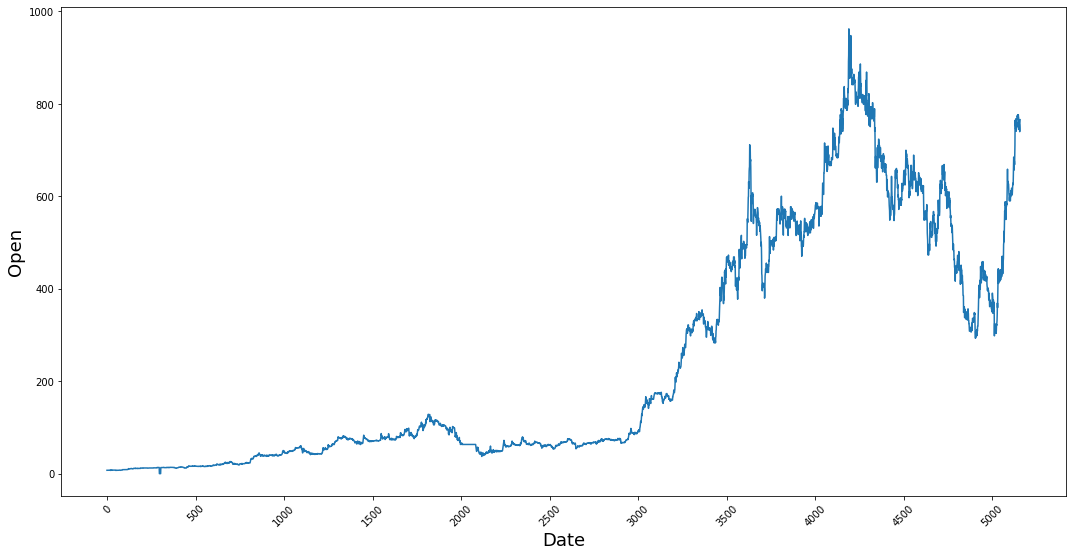

In [194]:
plt.figure(figsize = (18,9))
plt.plot(range(abl.shape[0]), abl['Open'])
plt.xticks(range(0, abl.shape[0], 500), rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open', fontsize=18)
plt.show()

## Test-Train-Validation Split

#### The data is split into 3 parts. 

#### The first is the train part where we provide the model real prices as input and labels. It analyses the prices and attempts to predict the next day price. When predicted, the actual price for that day is given so it can learn accordingly.

#### The second is the test part, where we provide the model data it has not seen before and ask it to predict using this new data entirely.

#### The third part is the validation part. We keep some data never shown to the model in train and test parts and then ask it to predict this without ever seeing it.

In [195]:
global dates

def test_train_split(df, column):

    prices = df[column] #We choose to predict the price of the given column
    dates = df['Date']

    # 80-20 split into Train-Test

    train_data = prices[:int(len(prices)*0.7)]
    test_data = prices[int(len(prices)*0.7):int(len(prices)*0.8)]
    val_data = prices[int(len(prices)*0.8):]
    dates = dates[int(len(dates)*0.8):]
    
    #Convert to ndarray

    train_data = np.asarray(train_data)
    test_data = np.asarray(test_data)
    val_data = np.asarray(val_data)
    
    #Transform data
    
    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    val_data = val_data.reshape(-1, 1)
    

    print(train_data.shape[0])
    print(test_data.shape[0])
    print(val_data.shape[0])

    
    return train_data, test_data, val_data
    
train_data, test_data, val_data = test_train_split(abl, 'Open')

3611
516
1032


## Check distribution of data with scaling

#### A recurrent neural network works better when data is squished between a limit. We want to see if scaling our data this way has any change on its distribution. 

In [196]:
''''fig1, ax1 = plt.subplots()
ax1.set_title('Data Distribution')
ax1.boxplot(train_data, patch_artist=True)

#tempScaler = MinMaxScaler()
#scaled_data = tempScaler.fit_transform(train_data)

fig1, ax1 = plt.subplots()
ax1.set_title('Scaled Data Distribution')
ax1.boxplot(scaled_data, patch_artist=True)'''




"'fig1, ax1 = plt.subplots()\nax1.set_title('Data Distribution')\nax1.boxplot(train_data, patch_artist=True)\n\n#tempScaler = MinMaxScaler()\n#scaled_data = tempScaler.fit_transform(train_data)\n\nfig1, ax1 = plt.subplots()\nax1.set_title('Scaled Data Distribution')\nax1.boxplot(scaled_data, patch_artist=True)"

#### We can see scaling our data does not change the distribution

## Prepare Train set

#### The data is prepared with the following methodology:

#### We take a window (set of days) to analyze the recent stock movemement. Based on that analysis, and the weight of historical learning (previous analyses), a prediction for  the window+1 day is made. The model compares the predicted price with the original price and adjusts its parameters. This is done iteratively, with a step of window+1 in each iteration. 

#### For example, for a window of 5, the model would look at day 1 to day 5 and predict day 6. Once day 6 is predicted, it would adjust parameters and then move onto the next window of day 7 to day 11 and predict day 12 and so on.

#### The days in the window are stored in x_train (the features). The days to be predicted are stored in y_train (labels). This results in two arrays, x_train and y_train which we would feed into the model

In [197]:
def train_prep(train_data, window):

    scaler = MinMaxScaler((0, 1))
    scaled_train_data = scaler.fit_transform(train_data)

    x_train = [] #Features
    y_train = [] #Labels

    for i in range(window, scaled_train_data.shape[0], window+1): #Make windows of 60 days for training until last day

        x_train.append(scaled_train_data[i-window:i]) #n day window to look back
        y_train.append(scaled_train_data[i:i+1, 0]) #predict for specified days

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    print(x_train.shape, y_train.shape, scaler.scale_)
    
    return x_train, y_train, scaler.scale_
    
x_train, y_train, scale_train = train_prep(train_data, 5)

(601, 5, 1) (601, 1) [0.00194006]


## Prepare test and validation set

#### Exactly the same way as train set, we will make the test set. The only difference is that the test set takes the last window from the train set so it can predict in continuation. 

In [237]:
def test_prep(test_data, train_data, window):
    
    scaler = MinMaxScaler((0, 1))
    test_data = np.concatenate((train_data[:window], test_data), axis = 0) #Add last previous observations of train data to test
    scaled_test_data = scaler.fit_transform(test_data)

    x_test = []
    y_test = []

    for i in range(window, test_data.shape[0], window+1):
        x_test.append(scaled_test_data[i-window:i])
        y_test.append(scaled_test_data[i:i+1, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
        
    print(x_test.shape, y_test.shape, scaler.scale_)
    return x_test, y_test, scaler.scale_
    
x_test, y_test, test_scale = test_prep(test_data, train_data, 5)

(86, 5, 1) (86, 1) [0.00135099]


In [238]:
def val_prep(val_data, test_data, window):
    
    scaler = MinMaxScaler((0, 1))
    val_data = np.concatenate((test_data[:window], val_data), axis = 0) #Add last previous observations of train data to test
    scaled_val_data = scaler.fit_transform(val_data)

    x_val = []
    y_val = []

    for i in range(window, val_data.shape[0], window+1):
        x_val.append(scaled_val_data[i-window:i])
        y_val.append(scaled_val_data[i:i+1, 0])

    x_val = np.array(x_val)
    y_val = np.array(y_val)
        
    print(x_val.shape, y_val.shape, scaler.scale_)
    return x_val, y_val, scaler.scale_
    
x_val, y_val, val_scale = val_prep(val_data, test_data, 5)

(172, 5, 1) (172, 1) [0.00149424]


## Building the LSTM

#### We chose the GRU model as it performed the best on our problem. The architecture is such that there are two layers of GRU. The first layer takes the input as we defined in train and test sets. It then forwards its results to the second layer which works similarly. Both layers are activated by ReLU on the output to ensure non-linearity of our problem. 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 5, 16)             864       
_________________________________________________________________
gru_12 (GRU)                 (None, 32)                4704      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


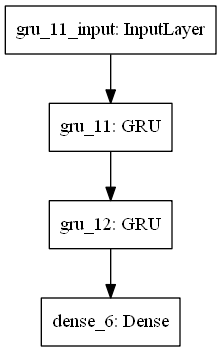

In [217]:
def create_model(x_train, units_1, units_2):

    model = Sequential()

    model.add(GRU(units = units_1, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))

    model.add(GRU(units = units_2, activation = 'relu'))

    model.add(Dense(units = 1))
    
    return model
    
    
model = create_model(x_train, 16, 32)

model.summary()

plot_model(model, to_file='model.png')

#### ADAM is an optimizer used to optimize the Stochastic Gradient Descent used to minimize the error the model makes. Mean Squared Error is the error or loss function used to tell the model how to minimize the error in each step. The number of epochs is defined as how many times the model would need to go through the whole data in order to reach the minimum point of the loss. We have chosen the number at which we are sure the loss becomes constant and does not drop significiantly anymore. The batch size is defined as how many training examples should it put in one batch since the parameters are adjusted after each batch.

In [218]:
def compile_model(model, x_train, y_train, x_test, y_test):

    model.compile(optimizer='adam', loss= 'mean_squared_error')
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data = (x_test, y_test), verbose = 1)
    return history

history = compile_model(model, x_train, y_train, x_test, y_test)
#model.save("LSTM")

Train on 601 samples, validate on 86 samples
Epoch 1/10
601/601 [==============================] - 2s 4ms/step - loss: 0.0596 - val_loss: 0.4250
Epoch 2/10
601/601 [==============================] - 0s 324us/step - loss: 0.0360 - val_loss: 0.2435
Epoch 3/10
601/601 [==============================] - 0s 280us/step - loss: 0.0227 - val_loss: 0.1401
Epoch 4/10
601/601 [==============================] - 0s 384us/step - loss: 0.0118 - val_loss: 0.0527
Epoch 5/10
601/601 [==============================] - 0s 397us/step - loss: 0.0015 - val_loss: 0.0072
Epoch 6/10
601/601 [==============================] - 0s 466us/step - loss: 2.4086e-04 - val_loss: 0.0052
Epoch 7/10
601/601 [==============================] - 0s 398us/step - loss: 8.3552e-05 - val_loss: 0.0053
Epoch 8/10
601/601 [==============================] - 0s 353us/step - loss: 5.9019e-05 - val_loss: 0.0052
Epoch 9/10
601/601 [==============================] - 0s 337us/step - loss: 5.5011e-05 - val_loss: 0.0052
Epoch 10/10
601/601 [==

## Testing

#### This is the part where we test our results. y_hat is an array which holds the predictions done on the test dataset we created earlier. After we have y_hat, we revert the scale of data to get original prices once again. These prices are then plotted to closely see how our model is behaving.

In [239]:
y_hat = model.predict(x_test) #Prediction over test set


In [240]:
y_hat_unscaled = y_hat/test_scale[0]
y_test_unscaled = y_test/test_scale[0]

#Scaling back to original values


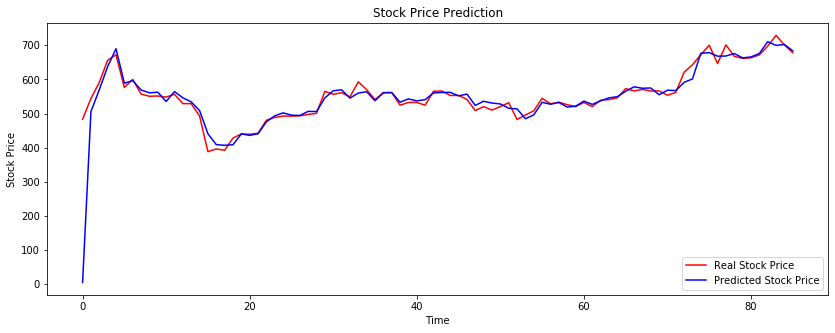

86


In [255]:
def plot_comparison(y_test, y_hat):

    plt.figure(figsize=(14,5))
    plt.plot(y_test[:], color = 'red', label = 'Real Stock Price')
    plt.plot(y_hat[:], color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
plot_comparison(y_test_unscaled, y_hat_unscaled)
print(len(y_hat_unscaled))

In [242]:
# Define plot space
#fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
#ax.scatter(range(y_test.shape[0]), 
#           y_test)

#ax.scatter(range(y_test.shape[0]), 
#           y_hat)

#plt.show()


## Validating



In [243]:
y_hat_val = model.predict(x_val) #Prediction over val set



In [244]:
y_hat_val_unscaled = y_hat_val/val_scale[0]
y_val_unscaled = y_val/val_scale[0]

#Scaling back to original values


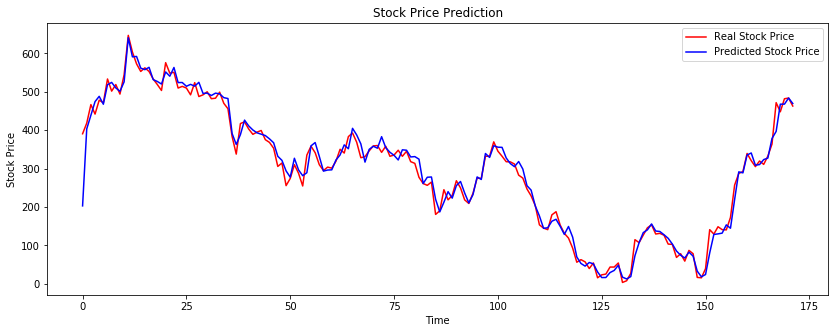

In [256]:
plot_comparison(y_val_unscaled, y_hat_val_unscaled)